<h2 style="color:dodgerblue"> 
ISEF 2024-25 Project
</h2>

<h4 style="color:white"> 
Quantum Error Correction Codes: Accuracy vs Time Complexity
</h4>

##### <span style="color: white;"> By: Sumer Chaudhary, BASIS Independent McLean
______________________
<h6 style="color:dodgerblue"> 
12/15/2024 - 
</h6>

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, Operator
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.circuit import IfElseOp
import numpy as np
import stac

In [2]:
def cxx(qc, c, q1, q2):
    qc.cx(c, q1)
    qc.cx(c, q2)

def cxxx(qc, c, q1, q2, q3):
    qc.cx(c, q1)
    qc.cx(c, q2)
    qc.cx(c, q3)

def cxxxx(qc, c, q1, q2, q3, q4): 
    qc.cx(c,q1)
    qc.cx(c,q2)
    qc.cx(c,q3)
    qc.cx(c,q4)

def czz(qc, c, q1, q2):
    qc.cz(c, q1)
    qc.cz(c, q2)

def czzz(qc, c, q1, q2, q3):
    qc.cz(c, q1)
    qc.cz(c, q2)
    qc.cz(c, q3)

def czzzz(qc, c, q1, q2, q3, q4): 
    qc.cz(c,q1)
    qc.cz(c,q2)
    qc.cz(c,q3)
    qc.cz(c,q4)

In [3]:
def encode_with_shors(qc, log_reg, anc_reg):
    cxx(qc, log_reg[0], anc_reg[2], anc_reg[5])

    qc.h(log_reg[0])
    qc.h(anc_reg[2])
    qc.h(anc_reg[5])

    cxx(qc, log_reg[0], anc_reg[0], anc_reg[1])

    cxx(qc, anc_reg[2], anc_reg[3], anc_reg[4])

    cxx(qc, anc_reg[5], anc_reg[6], anc_reg[7])

    qc.barrier()


def decode_with_shors(qc, log_reg, class_reg, anc_reg):
    cxx(qc, log_reg[0], anc_reg[0], anc_reg[1])

    cxx(qc, anc_reg[2], anc_reg[3], anc_reg[4])

    cxx(qc, anc_reg[5], anc_reg[6], anc_reg[7])

    qc.ccx(anc_reg[1], anc_reg[0], log_reg[0])
    qc.ccx(anc_reg[4], anc_reg[3], anc_reg[2])
    qc.ccx(anc_reg[7], anc_reg[6], anc_reg[5])

    qc.h(log_reg[0])
    qc.h(anc_reg[2])
    qc.h(anc_reg[5])

    cxx(qc, log_reg[0], anc_reg[2], anc_reg[5])

    qc.ccx(anc_reg[5], anc_reg[2], log_reg[0])

    qc.barrier()

In [43]:
def steane_error_correction(qc, x_ancillas, z_ancillas, logical_qubit, x_syndrome, z_syndrome):
    # Initialize the ancillas to |0>
    for i in range(3):
        qc.initialize([1,0], x_ancillas[i])
        qc.initialize([1,0], z_ancillas[i])
        
    # Apply Hadamard to the ancillas
    qc.h(x_ancillas)
    qc.h(z_ancillas)
    
    # Controlled g_i
    qc.cx(z_ancillas[2], [logical_qubit[i-1] for i in [4,5,6,7]]) # Controlled g1
    qc.cx(z_ancillas[1], [logical_qubit[i-1] for i in [2,3,6,7]]) # Controlled g2
    qc.cx(z_ancillas[0], [logical_qubit[i-1] for i in [1,3,5,7]]) # Controlled g3
    
    qc.cz(x_ancillas[2], [logical_qubit[i-1] for i in [4,5,6,7]]) # Controlled g4
    qc.cz(x_ancillas[1], [logical_qubit[i-1] for i in [2,3,6,7]]) # Controlled g5
    qc.cz(x_ancillas[0], [logical_qubit[i-1] for i in [1,3,5,7]]) # Controlled g6
    
    # Apply Hadamard to the ancillas
    qc.h(x_ancillas)
    qc.h(z_ancillas)
    
    # Measure the ancillas
    qc.measure(x_ancillas, x_syndrome)
    qc.measure(z_ancillas,z_syndrome)
    
    # Apply the corrective X gates
    for i in range(1,8):
        qc.x(logical_qubit[i-1]).c_if(x_syndrome,i)
    
    # Apply the corrective Z gates
    for i in range(1,8):
        qc.z(logical_qubit[i-1]).c_if(z_syndrome,i)

# Adds the logical Hadamard  gate to a QuantumCircuit qc
def logical_h(qc, logical_qubit):
    if not isinstance(qc, QuantumCircuit):
        raise TypeError("'qc', should be a QuantumCircuit")
        
    if not isinstance(logical_qubit, QuantumRegister):
        raise TypeError("'logical_qubit' should be a QuantumRegister")
    elif logical_qubit.size != 7:
        raise TypeError("'logical_qubit' must have 7 qubits")

    qc.h(logical_qubit)

# Adds the logical CNOT gate to a QuantumCircuit qc with logical qubit 'control' as the control
# and 'target' as target
def logical_cx(qc, control, target):
    if not isinstance(qc, QuantumCircuit):
        raise TypeError("'qc', should be a QuantumCircuit")
        
    if not isinstance(control, QuantumRegister):
        raise TypeError("'control' should be a QuantumRegister")
    elif control.size != 7:
        raise TypeError("'control' must have 7 qubits")
    
    if not isinstance(control, QuantumRegister):
        raise TypeError("'control' should be a QuantumRegister")
    elif control.size != 7:
        raise TypeError("'control' must have 7 qubits")

    for i in range(7):
        qc.cx(control[i],target[i])

# Measures logical_qubit in the Z basis using ancilla, in the circuit qc
def logical_z_measure(qc, ancilla, logical_qubit, measurement):
    # Make sure the inputs are valid
    if not isinstance(qc, QuantumCircuit):
        raise TypeError("'qc' should be a QuantumCircuit")
    
    if not isinstance(ancilla, QuantumRegister):
        raise TypeError("'ancilla' should be a QuantumRegister")
    elif ancilla.size != 1:
        raise TypeError("'ancilla' must have 1 qubit")
    
    if not isinstance(logical_qubit, QuantumRegister):
        raise TypeError("'logical_qubit'should be a QuantumRegister")
    elif logical_qubit.size != 7:
        raise TypeError("'logical_qubit' must have 7 qubits")
    
    if not isinstance(measurement, ClassicalRegister):
        raise TypeError("'measurement' should be a ClassicalRegister")
    elif measurement.size != 1:
        raise TypeError("'measurement' must have 1 bit")
        
    # Initialize ancilla to |0>
    qc.initialize([1,0],ancilla)
    
    # Apply Hadamard to ancilla
    qc.h(ancilla)
    # Apply controlled logical-Z
    for i in range(7):
        qc.cz(ancilla, logical_qubit[i])
    # Apply Hadamard to ancilla
    qc.h(ancilla)
    
    # Measure the ancilla
    qc.measure(ancilla, measurement)

In [67]:
def encode_with_steane(qc, lq, stab_reg):
    cxx(qc, lq, stab_reg[4], stab_reg[5])
    
    qc.barrier()

    qc.h(stab_reg[0])
    cxxx(qc, stab_reg[0], stab_reg[3], stab_reg[5], lq)

    qc.barrier()

    qc.h(stab_reg[1])
    cxxx(qc, stab_reg[1], stab_reg[3], stab_reg[4], lq)

    qc.barrier()

    qc.h(stab_reg[2])
    cxxx(qc, stab_reg[2], stab_reg[3], stab_reg[4], stab_reg[5])

    qc.barrier()

def steane_measure_syndrome(qc, lq, stab_reg, anc_reg, class_reg):
    for i in range(6):
        qc.h(anc_reg[i])

    qc.barrier()

    cxxxx(qc, anc_reg[0], stab_reg[0], stab_reg[4], stab_reg[5], lq)

    qc.barrier()

    cxxxx(qc, anc_reg[1], stab_reg[1], stab_reg[3], stab_reg[5], lq)

    qc.barrier()

    cxxxx(qc, anc_reg[2], stab_reg[2], stab_reg[3], stab_reg[4], stab_reg[5])
    
    qc.barrier()

    czzzz(qc, anc_reg[3], stab_reg[0], stab_reg[4], stab_reg[5], lq)

    qc.barrier()

    czzzz(qc, anc_reg[4], stab_reg[1], stab_reg[3], stab_reg[5], lq)

    qc.barrier()

    czzzz(qc, anc_reg[5], stab_reg[2], stab_reg[3], stab_reg[4], stab_reg[5])

    qc.barrier()

    for i in range(6):
        qc.h(anc_reg[i])
        qc.measure(anc_reg[i], class_reg[i])

    qc.barrier()
    
def decode_with_steane(qc, lq, stab_reg, output_reg):
    qc.cx(stab_reg[0], output_reg[0])
    qc.cx(stab_reg[1], output_reg[0])

    qc.barrier()

    qc.cx(lq, output_reg[0])

    qc.barrier()

    cxxx(qc, output_reg[0], stab_reg[4], stab_reg[5], lq)

    qc.barrier()

In [6]:
from qiskit_aer.noise import NoiseModel, errors
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import depolarizing_error, readout_error
 
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(
    50e3, 10e3, 4
)  # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(
    70e3, 10e3, 4
)  # Sampled from normal distribution mean 50 microsec
 
# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])
 
# Instruction times (in nanoseconds)
time_u1 = 0  # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100  # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000  # 1 microsecond
 
# QuantumError objects
errors_reset = [
    errors.thermal_relaxation_error(t1, t2, time_reset) for t1, t2 in zip(T1s, T2s)
]
errors_measure = [
    errors.thermal_relaxation_error(t1, t2, time_measure) for t1, t2 in zip(T1s, T2s)
]
errors_u1 = [
    errors.thermal_relaxation_error(t1, t2, time_u1) for t1, t2 in zip(T1s, T2s)
]
errors_u2 = [
    errors.thermal_relaxation_error(t1, t2, time_u2) for t1, t2 in zip(T1s, T2s)
]
errors_u3 = [
    errors.thermal_relaxation_error(t1, t2, time_u3) for t1, t2 in zip(T1s, T2s)
]
errors_cx = [
    [
        errors.thermal_relaxation_error(t1a, t2a, time_cx).expand(
            errors.thermal_relaxation_error(t1b, t2b, time_cx)
        )
        for t1a, t2a in zip(T1s, T2s)
    ]
    for t1b, t2b in zip(T1s, T2s)
]
 
# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

backend = AerSimulator(noise_model=noise_thermal, method="matrix_product_state")

passmanager = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

<h3 style="color:white"> 
Control Group
</h4>

In [7]:
q = QuantumRegister(2, 'q')
c = ClassicalRegister(2, 'c')
qc = QuantumCircuit(q,c)

#Bell State
qc.h(q[0])
qc.cx(q[0],q[1])

#Measure
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])

qc.draw("mpl", initial_state=True, scale=0.5, fold=-1, style="clifford", reverse_bits=False, plot_barriers=False, filename="Diagrams/control.png")

noisy_circ = passmanager.run(qc)

result = backend.run(noisy_circ, shots=8192).result()
plot_histogram(result.get_counts(0), filename="Results/control.png")

<h3 style="color:white"> 
Shor's Error Correction Code
</h3>

In [50]:
q1 = QuantumRegister(1, 'q1')
q2 = QuantumRegister(1, 'q2')
c = ClassicalRegister(2,'c')
a1 = AncillaRegister(8, 'a1')
a2 = AncillaRegister(8, 'a2')
qc = QuantumCircuit(q1,a1,q2,a2,c)

qc.initialize(0, a1)
qc.initialize(0, a2)

qc.barrier()

#Bell State
qc.h(q1[0])
qc.cx(q1[0],q2[0])

qc.barrier()

#Encode
encode_with_shors(qc, q1, a1)
encode_with_shors(qc, q2, a2)

#Decode
decode_with_shors(qc, q1, c, a1)
decode_with_shors(qc, q2, c, a2)

#Measure
qc.measure(q1[0], c[0])
qc.measure(q2[0], c[1])

qc.draw("mpl", initial_state=True, scale=0.5, fold=-1, style="clifford", reverse_bits=False, plot_barriers=False, filename="Diagrams/shor.png")

noisy_circ = passmanager.run(qc)

result = backend.run(noisy_circ, shots=8192).result()

plot_histogram(result.get_counts(0), filename="Results/shor.png")

<h3 style="color:white"> 
Steane Error Correction Code
</h3>

/var/folders/m1/m9y8lmf94db5f24wfgkkb1l80000gn/T/ipykernel_61991/3719194965.py:30: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(logical_qubit[i-1]).c_if(x_syndrome,i)
/var/folders/m1/m9y8lmf94db5f24wfgkkb1l80000gn/T/ipykernel_61991/3719194965.py:34: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.z(logical_qubit[i-1]).c_if(z_syndrome,i)


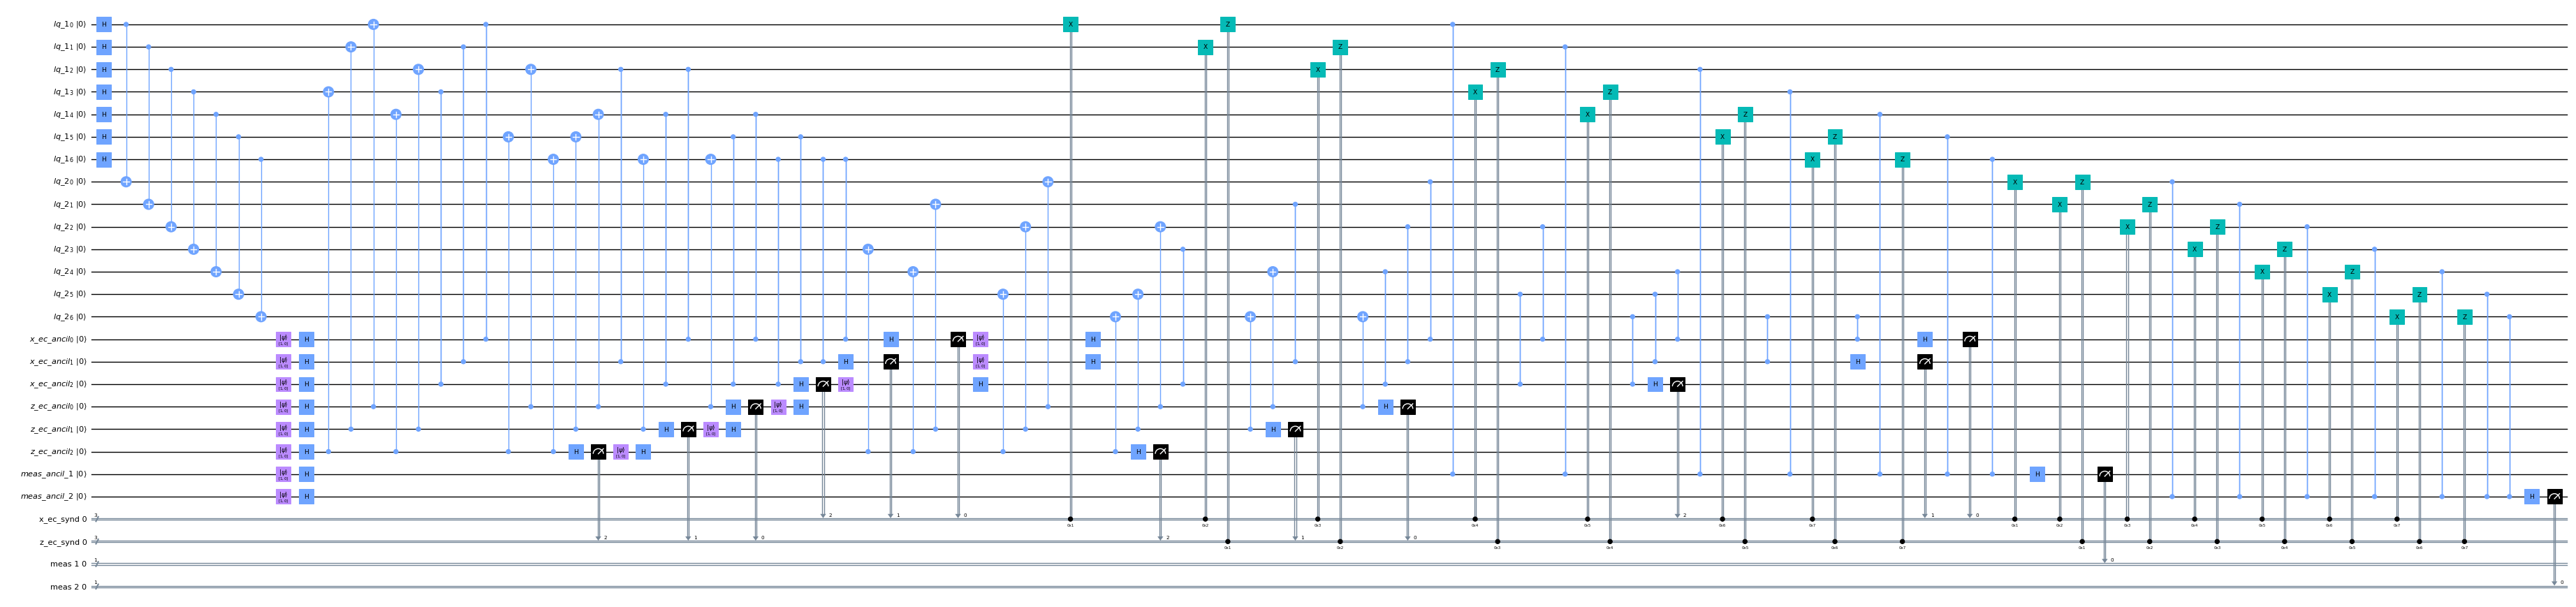

In [44]:
# The logical qubits
lq_1 = QuantumRegister(7,name='lq_1')
lq_2 = QuantumRegister(7,name='lq_2')

# Error Correction Ancillas
x_ec_ancilla = QuantumRegister(3,name='x_ec_ancil')
z_ec_ancilla = QuantumRegister(3,name='z_ec_ancil')

x_ec_syndrome = ClassicalRegister(3,name='x_ec_synd')
z_ec_syndrome = ClassicalRegister(3,name='z_ec_synd')

# Measurement Ancillas
z_meas_ancilla_1 = QuantumRegister(1,name='meas_ancil_1')
z_meas_ancilla_2 = QuantumRegister(1,name='meas_ancil_2')

z_meas_1 = ClassicalRegister(1,name='meas 1')
z_meas_2 = ClassicalRegister(1,name='meas 2')

# Define the quantum circuit on these registers
qc = QuantumCircuit(lq_1, lq_2,
                    x_ec_ancilla, z_ec_ancilla, z_meas_ancilla_1, z_meas_ancilla_2,
                    x_ec_syndrome, z_ec_syndrome, z_meas_1, z_meas_2)

# Apply the Hadamard gate
logical_h(qc, lq_1)    

# Apply the CNOT gate
logical_cx(qc, lq_1, lq_2)

qc.barrier()

steane_error_correction(qc, x_ec_ancilla, z_ec_ancilla, lq_1, x_ec_syndrome, z_ec_syndrome)
steane_error_correction(qc, x_ec_ancilla, z_ec_ancilla, lq_2, x_ec_syndrome, z_ec_syndrome)

# Measure the qubits
logical_z_measure(qc, z_meas_ancilla_1, lq_1, z_meas_1)
logical_z_measure(qc, z_meas_ancilla_2, lq_2, z_meas_2)

qc.draw("mpl", initial_state=True, scale=0.5, fold=-1, style="clifford", reverse_bits=False, plot_barriers=False, filename="Diagrams/steane.png")

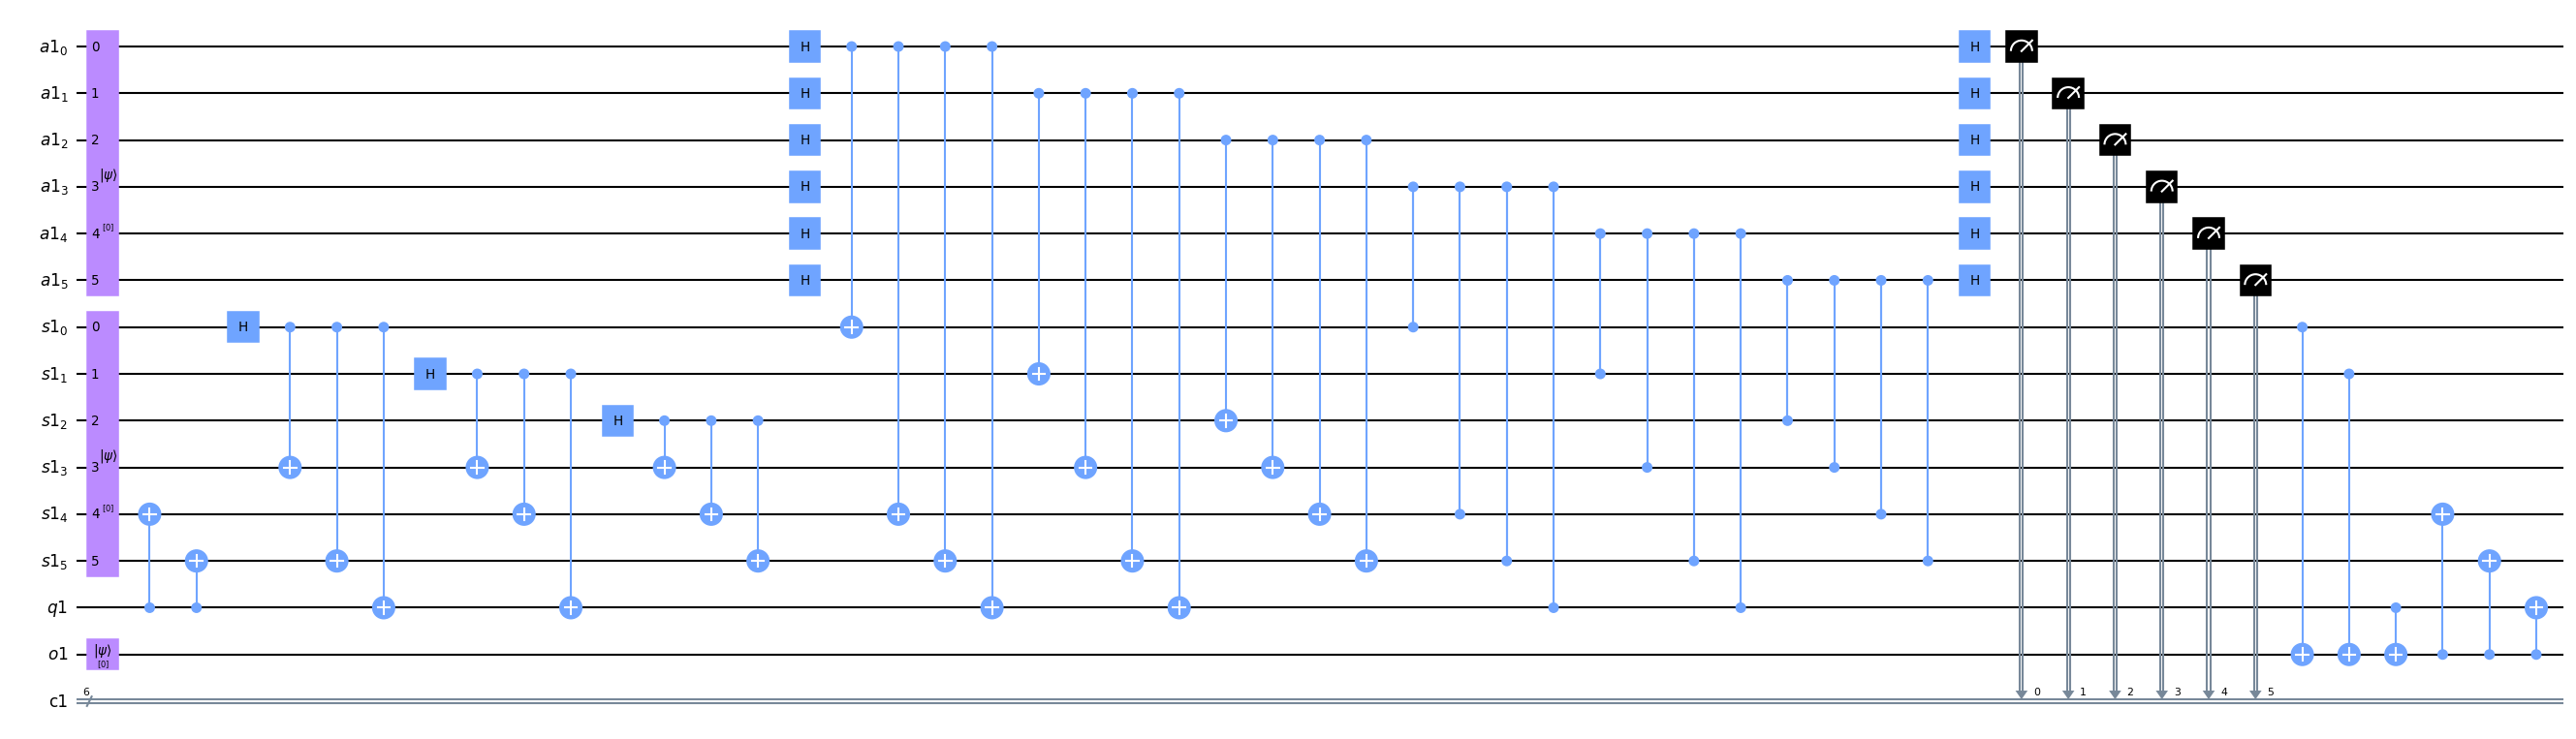

In [68]:
q1 = QuantumRegister(1, 'q1')
s1 = AncillaRegister(6, 's1')
o1 = AncillaRegister(1, 'o1')
a1 = AncillaRegister(6, 'a1')
c1 = ClassicalRegister(6, 'c1')
qc = QuantumCircuit(a1, s1, q1, o1, c1)

qc.initialize(0, s1)
qc.initialize(0, o1)
qc.initialize(0, a1)

qc.barrier()

#Encode Qubits
encode_with_steane(qc, q1[0], s1)

#Measure Syndrome
steane_measure_syndrome(qc, q1[0], s1, a1, c1)

#Correct Errors

#Decode Qubits
decode_with_steane(qc, q1[0], s1, o1)

qc.draw("mpl", style="clifford", scale=0.75, fold=-1, plot_barriers=False)

In [45]:
result = backend.run(noisy_circ, shots=8192).result()

In [46]:
proc_results = {"00" : 0, "01" : 0, "10" : 0, "11" : 0}
for res in result.get_counts(0):
    proc_results[res[:4]] += result.get_counts(0)[res]
print(proc_results)
plot_histogram(proc_results, figsize=(13,13), filename="Results/steane.png")

{'00': 4050, '01': 31, '10': 154, '11': 3957}


<h3 style="color:white"> 
Five-qubit Error Correction Code
</h3>